
# AI vs IA
---

#### Group 12

This notebook contains our work for the **AI vs IA** subject at the **IA Data Hack** hackaton.<br><br>
The structure is the following:
- Subject understanding
- Data analysis and transformation
- Models benchmark
- Best model optimisation
- Conclusion

We are using the library ```scikit-learn``` for a part of the benchmark, which runs only on CPU, so it takes a lot of time training different models.<br>
There will be the comment ```DO NOT RUN``` on specific part of the benchmark because it would be too long to run, you have to trust us on our result !

## Subject understanding
---

The subject of this hackaton is, as said before, **AI vs IA**. Given some text, we need to define if the sentence was created by a **human** or an **AI**.<br>
Therefore, we consider this problem as a ***classification*** problem, especially a ***binary classification*** problem. Binary classification is a common problem in artificial intelligence, which require ***machine learning*** or ***deep learning*** models. We will use both and compare them in our benchmark to get the best one.<br>
For binary classification problem, we use the ```binary cross entropy``` loss function, which is the most suitable, and calculated as follows:

$$
BCE = -y \cdot \log(p) - (1 - y) \cdot \log(1 - p)
$$

Where:
- *y* is the true label (0 or 1)
- *p* is the predicted probability (between 0 and 1)


## Data analysis and transformation
---

### Libraries import

In [2]:
import os

import pandas as pd
import s3fs
import zipfile

import time
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score,recall_score, precision_score, f1_score, ConfusionMatrixDisplay, confusion_matrix


#### Get dataset from aws

In [3]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [4]:
file_path = "data.csv"

# Télécharger les données dans le service
fs.download("civel/diffusion/hackathon-minarm-2024/AIVSAI/hack_train.csv", file_path)

[None]

In [13]:
df = pd.read_csv(file_path).drop(['src'], axis=1)
df.head()

,text,label
0,Little disclaimer: this deals with US laws and...,1
1,"Read: Mentally Retarded Downs. See, we've got ...",1
2,"If any of you frequent rbadhistory, there is a...",1
3,"I believe in a flat tax system, where everyone...",1
4,"Edit: Ok guy's, my views have been changed on ...",1


In [6]:
description = pd.DataFrame()
description['description_length'] = df.text.apply(len)
print("Mean description length: ", description['description_length'].mean())
print("Min overview length: ", description['description_length'].min())
print("Max overview length: ", description['description_length'].max())

Mean description length:  1230.0178461430155
Min overview length:  24
Max overview length:  63723


### Words with bad spelling

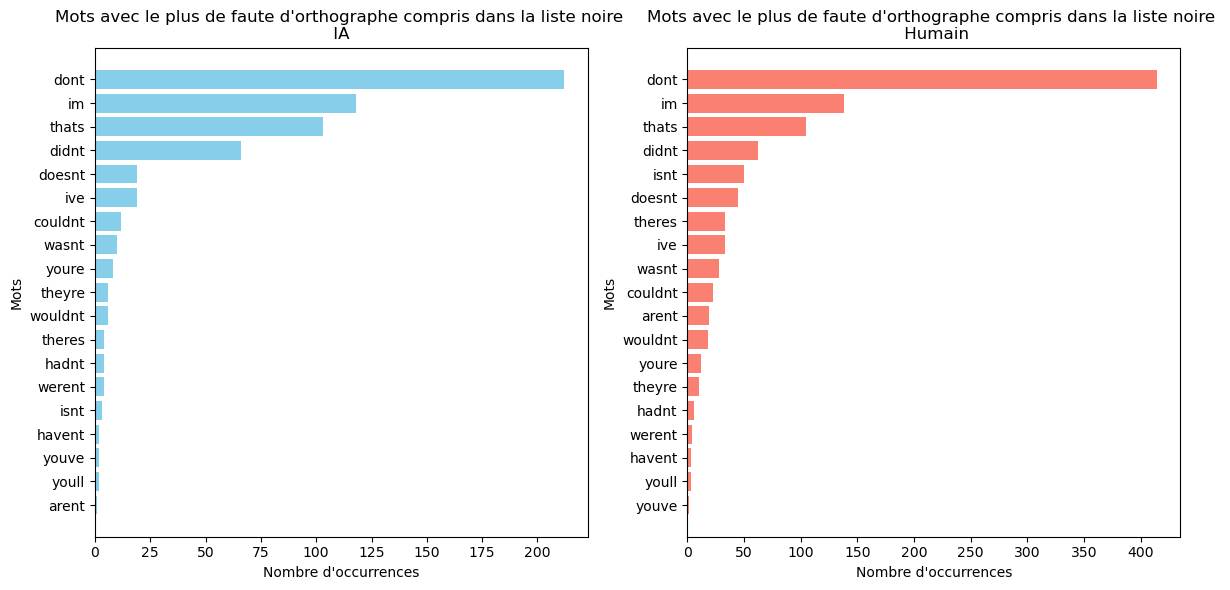

In [37]:
blacklisted_words = {"didnt", "dont", "im", "youre", "ive", "doesnt", "wasnt", "couldnt", "thats", "isnt", "theres", "theyre", "wouldnt", "arent", "youll", "Dont", "youve", "havent", "hadnt", "werent"}

# Dictionnaire pour compter les occurrences des mots de la liste noire dans les textes pour chaque label
blacklisted_counts_label_0 = {word: 0 for word in blacklisted_words}
blacklisted_counts_label_1 = {word: 0 for word in blacklisted_words}

# Parcourir chaque texte pour compter les occurrences exactes des mots de la liste noire
for index, row in df.iterrows():
    text = row['text']
    words_in_text = text.split()
    for word in blacklisted_words:
        for word_in_text in words_in_text:
            if word_in_text.lower() == word.lower():
                if row['label'] == 0:
                    blacklisted_counts_label_0[word.lower()] += 1
                else:
                    blacklisted_counts_label_1[word.lower()] += 1

# Filtrer les mots avec au moins une occurrence pour chaque label
filtered_counts_label_0 = {word: count for word, count in blacklisted_counts_label_0.items() if count > 0}
filtered_counts_label_1 = {word: count for word, count in blacklisted_counts_label_1.items() if count > 0}

# Trier dictionnaire par valeur pour obtenir les mots avec le plus d'occurrences pour chaque label
sorted_counts_label_0 = sorted(filtered_counts_label_0.items(), key=lambda x: x[1], reverse=True)
sorted_counts_label_1 = sorted(filtered_counts_label_1.items(), key=lambda x: x[1], reverse=True)

# Extraction data pour graphique pour label 0
words_label_0 = [word for word, count in sorted_counts_label_0]
counts_label_0 = [count for word, count in sorted_counts_label_0]

# Extraction data pour graphique pour label 1
words_label_1 = [word for word, count in sorted_counts_label_1]
counts_label_1 = [count for word, count in sorted_counts_label_1]

# Tunning graphique pour label 0
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(words_label_0, counts_label_0, color='skyblue')
plt.xlabel('Nombre d\'occurrences')
plt.ylabel('Mots')
plt.title('Mots avec le plus de faute d\'orthographe compris dans la liste noire \n IA ')
plt.gca().invert_yaxis()  

# Tunning graphique pour label 1
plt.subplot(1, 2, 2)
plt.barh(words_label_1, counts_label_1, color='salmon')
plt.xlabel('Nombre d\'occurrences')
plt.ylabel('Mots')
plt.title('Mots avec le plus de faute d\'orthographe compris dans la liste noire \n Humain')
plt.gca().invert_yaxis()  

plt.tight_layout()
plt.show()

### Comparison of the number of letters between AI and human

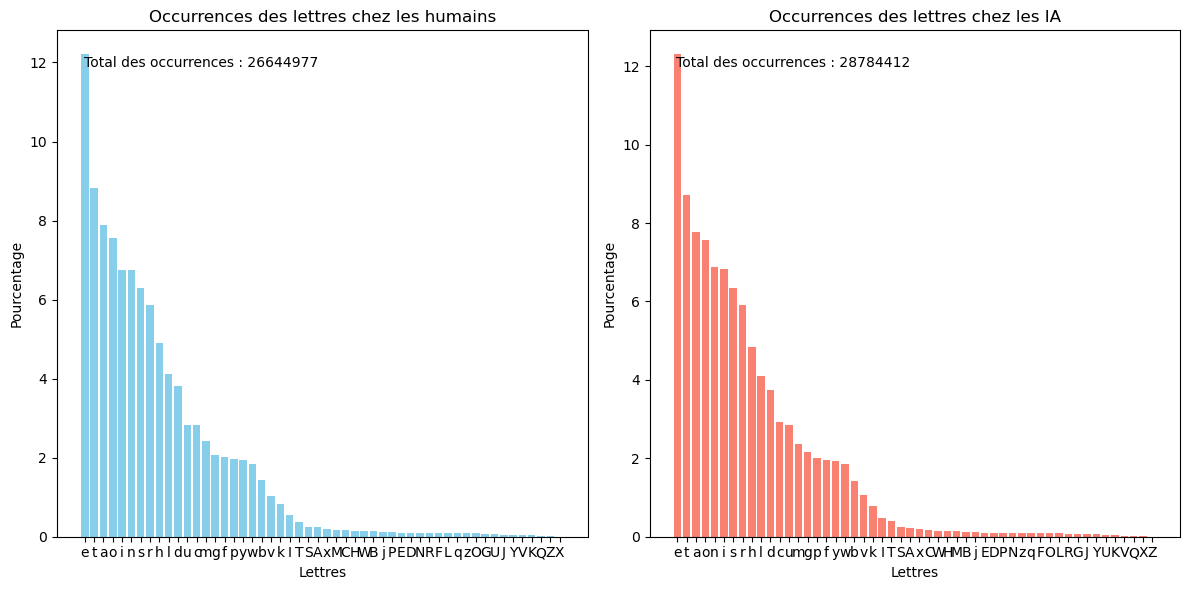

In [34]:
def count_all_letters(text):
    all_text = ''.join(text)
    letter_count = {}
    for char in all_text:
        if char.isalpha():
            letter_count[char] = letter_count.get(char, 0) + 1
    return letter_count

# 2 sous df
df_label_1 = df[df['label'] == 1]
df_label_2 = df[df['label'] == 0]

# Compter les occurrences de toutes les lettres pour chaque label
letter_count_label_1 = count_all_letters(df_label_1['text'])
letter_count_label_2 = count_all_letters(df_label_2['text'])

# Trier les données par nombre d'occurrences dans l'ordre décroissant
sorted_letter_count_label_1 = dict(sorted(letter_count_label_1.items(), key=lambda item: item[1], reverse=True))
sorted_letter_count_label_2 = dict(sorted(letter_count_label_2.items(), key=lambda item: item[1], reverse=True))

# Extraire les lettres et les occurrences pour chaque label
letters_1 = list(sorted_letter_count_label_1.keys())
counts_1 = list(sorted_letter_count_label_1.values())

letters_2 = list(sorted_letter_count_label_2.keys())
counts_2 = list(sorted_letter_count_label_2.values())

# Trouver la lettre la plus comptée pour chaque label
most_common_letter_1 = letters_1[0]
most_common_count_1 = counts_1[0]

most_common_letter_2 = letters_2[0]
most_common_count_2 = counts_2[0]

# Calcul du total des occurrences de toutes les lettres pour chaque label
total_count_1 = sum(counts_1)
total_count_2 = sum(counts_2)

# Calcul des pourcentages
percentage_counts_1 = [count / total_count_1 * 100 for count in counts_1]
percentage_counts_2 = [count / total_count_2 * 100 for count in counts_2]

plt.figure(figsize=(12, 6))

# Label 1 = Humain : 1 
plt.subplot(1, 2, 1)
plt.bar(letters_1, percentage_counts_1, color='skyblue')
plt.title('Occurrences des lettres chez les humains')
plt.xlabel('Lettres')
plt.ylabel('Pourcentage')
plt.text(0.05, 0.95, f"Total des occurrences : {total_count_1}", transform=plt.gca().transAxes, verticalalignment='top')

# Label 2 = IA : 0
plt.subplot(1, 2, 2)
plt.bar(letters_2, percentage_counts_2, color='salmon')
plt.title('Occurrences des lettres chez les IA')
plt.xlabel('Lettres')
plt.ylabel('Pourcentage')
plt.text(0.05, 0.95, f"Total des occurrences : {total_count_2}", transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

### word cloud : human responses

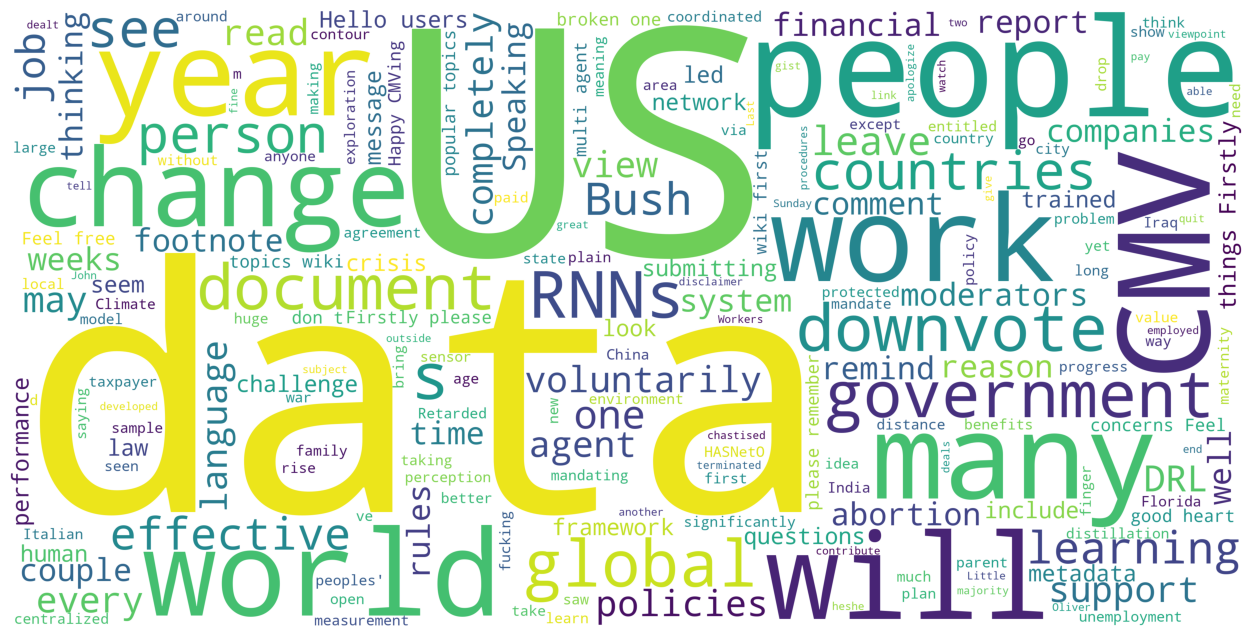

In [ ]:
stopwords = set(STOPWORDS)
human = df[df['label'] == True]
action_text = human['text'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(action_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

word cloud : AI responses

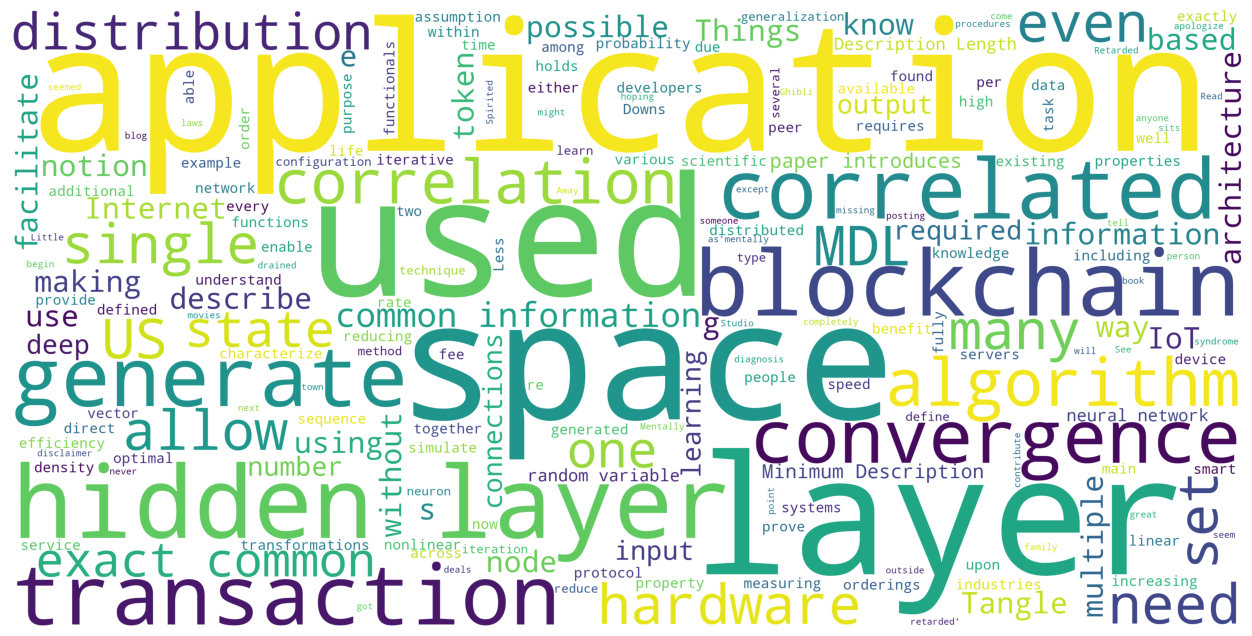

In [ ]:
stopwords = set(STOPWORDS)
human = df[df['label'] == False]
action_text = human['text'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(action_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Proportion des réponses entre humains/machines

In [ ]:
df2= pd.read_csv("data/data.csv")

In [ ]:
srcg=[]
for ind, row in df2.iterrows() : 
    if "human" in row.src :
        srcg.append("Human")
    elif "machine" in row.src :
        srcg.append("Machine")
df2["srcg"]=srcg

<Axes: title={'center': 'Proportion hum/gpt'}, xlabel='srcg'>

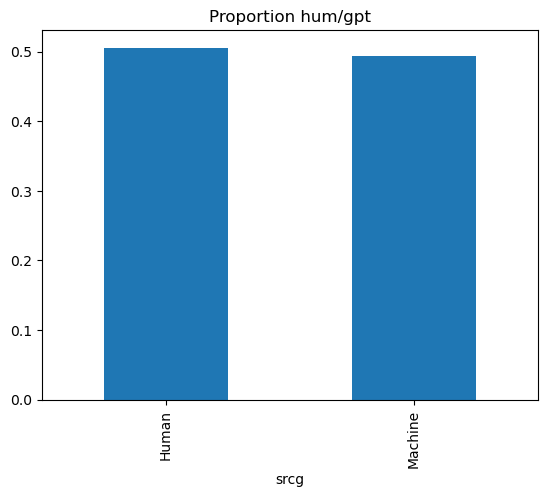

In [ ]:
df2.value_counts("srcg", normalize=True).plot(kind="bar", title= "Proportion hum/gpt")

### Slicing du dataset en fonction de la source

In [ ]:
df2hum=df2[df2.srcg=="Human"]
df2gpt=df2[df2.srcg=="Machine"]

### Analyse pour comparer la longueur des réponses humaines et machines

In [ ]:
lenrepdf2hum=[]
for i in df2hum.text:
    lenrepdf2hum.append(len(i))

lenrepdf2gpt=[]
for i in df2gpt.text:
    lenrepdf2gpt.append(len(i))

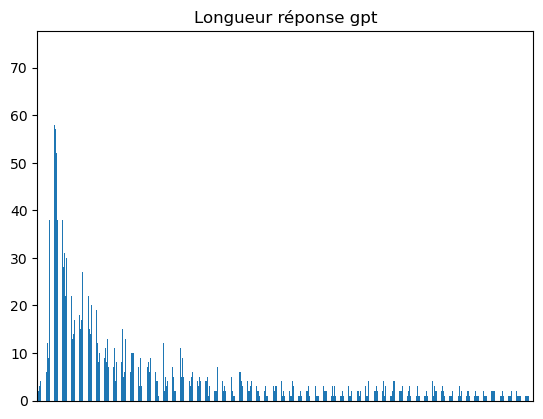

In [ ]:
pd.Series(lenrepdf2gpt).value_counts().sort_index().plot(kind="bar", title= "Longueur réponse gpt")
plt.xticks([])
plt.show()

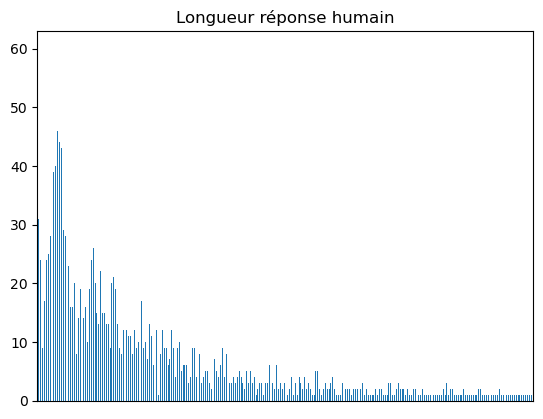

In [ ]:
pd.Series(lenrepdf2hum).value_counts().sort_index().plot(kind="bar", title= "Longueur réponse humain")
plt.xticks([])
plt.show()

## Models benchmark
---

In [ ]:
X = df['text']  
y = df['label']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

In [ ]:
models = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {'model__n_estimators': [50, 100, 200]}
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 1.0]}
    },
    'SVM': {
        'model': SVC(),
        'params': {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto']}
    },
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {'model__C': [0.1, 1, 10]}
    },
    'Naive Bayes': {
        'model': MultinomialNB(),
        'params': {'model__alpha': [0.01, 0.1, 1]}
    }
}

grid_search_objects = {}
results = {}

for name, m in models.items():
    pipe = Pipeline([
        ('count_vect', CountVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2))),
        ('tfidf_transformer', TfidfTransformer()),
        ('model', m['model'])
    ])
    grid_search = GridSearchCV(pipe, m['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    grid_search_objects[name] = grid_search
    results[name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_
    }

for name, res in results.items():
    print(f"{name}: Meilleure précision = {res['best_score']}")
    print(f"Meilleurs paramètres : {res['best_params']}")


In [ ]:

# Évaluation des meilleurs modèles sur le test set avec des métriques supplémentaires
test_results = {}
for name, grid_search in grid_search_objects.items():
    best_model = grid_search.best_estimator_
    
    start_time = time.time()
    y_pred = best_model.predict(X_test)
    end_time = time.time()
    prediction_time = end_time - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    test_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'prediction_time': prediction_time,
        'classification_report': classification_report(y_test, y_pred)
    }

    print(f"{name} Test Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Prediction Time: {prediction_time} seconds")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


## Best model optimisation
---

### SVM model

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear', 'poly']}
svm = SVC()

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

print("Meilleurs paramètres trouvés via la recherche sur la grille : ", grid_search.best_params_)
print("Meilleure précision moyenne lors de la validation croisée : ", grid_search.best_score_)


In [ ]:
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=final_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot()
plt.show()

In [ ]:
cv_scores = cross_val_score(final_model, X, y, cv=5, scoring = 'f1_macro', n_jobs = -1)
print("Précisions de validation croisée : ", cv_scores)
print("Précision moyenne de validation croisée : ", cv_scores.mean())

### BERT model

## Conclusion
---